In [1]:
using Plots, DifferentialEquations
using LinearAlgebra
using NLopt
using .Threads 
using Interpolations
using Distributions
using Roots
gr()
a=zeros(4) #parameter vector for unknown parameters
λg =0.005; Kg=80.0; C0g=2.0; σg  =2.0;  #initial parameter estimates
t=[0, 769,1140,1488,1876,2233,2602,2889,3213,3621,4028]; #observation times
data = [0.133333333,4.115503909,10.82448589,26.29988404,41.62258065,52.1,57.29019608,51.74864865,61.9804878,72.16281407,69.66331658]; #data


(process:3552): GLib-GIO-WARNING **: 18:02:23.566: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.1.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


In [2]:
function DE!(dC,C,p,t) #function to define process model
λ,K=p  #parameter vector for the process model
dC[1]=λ*C[1]*(1.0-C[1]/K); #define differential equation
end

DE! (generic function with 1 method)

In [3]:
function odesolver(t,λ,K,C0)  #function to solve the process model
p=(λ,K) # parameter vector for the process model
tspan=(0.0,maximum(t)) #time horizon
prob=ODEProblem(DE!,[C0],tspan,p) #define ODE model
sol=solve(prob,saveat=t) #solve and save solutions
return sol[1,:]
end

odesolver (generic function with 1 method)

In [4]:
function model(t,a) #function to solve the process model
y=zeros(length(t))
y=odesolver(t,a[1],a[2],a[3]) #solve the process model
    return y
end

model (generic function with 1 method)

In [5]:
function error(data,a) #function to evaluate the loglikelihood for the data given parameters a
    y=zeros(length(t))
    y=model(t,a);
    e=0;
    dist=Normal(0,a[4]);
    e=loglikelihood(dist,data-y) 
    return sum(e)
end

error (generic function with 1 method)

In [6]:
function fun(a) #function to evaluate the loglikelihood as a function of the parameters a 
return error(data,a)
end

fun (generic function with 1 method)

In [7]:
function optimise(fun,θ₀,lb,ub;  #NLopt routine to maximise the function fun, with parameter estimates \theta_0 subject to bound constraints
    dv = false,
    method = dv ? :LD_LBFGS : :LN_BOBYQA,
)

if dv || String(method)[2] == 'D'
    tomax = fun
else
    tomax = (θ,∂θ) -> fun(θ)
end

opt = Opt(method,length(θ₀))
opt.max_objective = tomax
opt.lower_bounds = lb       # Lower bound
opt.upper_bounds = ub       # Upper bound
#opt.local_optimizer = Opt(:LN_BOBYQA, length(θ₀))
opt.local_optimizer = Opt(:LN_NELDERMEAD, length(θ₀))
res = optimize(opt,θ₀)
return res[[2,1]]
end

optimise (generic function with 1 method)

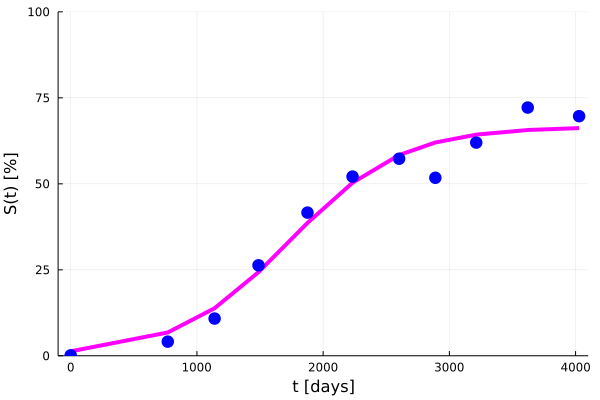

4-element Vector{Float64}:
  0.002258432986617795
 66.56506385496145
  1.3046116307946518
  4.26483659207521

In [8]:
Cmle=zeros(length(t))
θG = [λg,Kg,C0g,σg] #parameter estimates
lb=[0,0,0,0] #lower bound
ub=[1,100,10,10] #upper bound
(xopt,fopt)  = optimise(fun,θG,lb,ub) #call numerical optimization routine to give the vector of parameters xopt, and the maximum loglikelihood fopt
fmle=fopt; 
λmle=xopt[1]; 
Kmle=xopt[2]; 
C0mle=xopt[3]; 
σmle=xopt[4];
for j in 1:length(t)
Cmle[j] = Kmle*C0mle/((Kmle-C0mle)*exp(-λmle*t[j])+C0mle);
end    #evaluate the solution at the mle 
p1=plot(t,Cmle,color=:fuchsia,xlabel="t [days]",ylabel="S(t) [%]",legend=false,lw=4,xlims=(-100,4100),ylims=(0,100),xticks=[0,1000,2000,3000,4000],yticks=[0,25,50,75,100])
p1=scatter!(t,data,legend=false,msw=0,ms=7,color=:blue,msa=:blue)
display(p1)  #plot the data and solutions 
savefig(p1, "mle_S3.pdf")
xopt

In [9]:
#Profile λ
nptss=40 #points on the profile
λmin=0.001 #lower bound for the profile - can be changed easily
λmax=0.005 #upper bound for the profile - can be changed easily
λrange=LinRange(λmin,λmax,nptss) #vector of λ values along the profile
nrange=zeros(3,nptss) #matrix to store the nuisance parameters once optimized out
llλ=zeros(nptss) #loglikelihood at each point along the profile
nllλ=zeros(nptss) #normalised loglikelihood at each point along the profile
predictλ=zeros(length(t),nptss) #vector to store predictions at each point along the profile

for i in 1:nptss
function fun1(aa)  #function to return loglikelihood by fixing the interest parameter along the profile
return error(data,[λrange[i],aa[1],aa[2],aa[3]])
end

local lb1=[0.0,0.0,0.0] #lower bound 
local ub1=[100,10,10] #upper bound
local θG1 = [Kmle,C0mle,σmle] #initial estimate - take the MLE 
local (xo,fo)=optimise(fun1,θG1,lb1,ub1) #numerical optimisation
nrange[:,i]=xo[:]
llλ[i]=fo[1]
predictλ[:,i]=model(t,[λrange[i],nrange[1,i],nrange[2,i],nrange[3,i]]) # make prediction at the optimised numerical values
end

nllλ=llλ.-maximum(llλ); #calculate normalised loglikelihood


λp=zeros(length(t))
λm=1000*ones(length(t))

for i in 1:nptss
if nllλ[i] >= -1.921 #for all predictions where the normalised loglikelihood is above the threshold calculate the maximum/minimum predictions
    for j in 1:length(t)
    λp[j]=max(predictλ[j,i],λp[j])
    λm[j]=min(predictλ[j,i],λm[j])
    end
end

end


In [10]:
#Profile K
Kmin=55
Kmax=90
Krange=LinRange(Kmin,Kmax,nptss)
nrange=zeros(3,nptss)
llK=zeros(nptss)
nllK=zeros(nptss)
predictK=zeros(length(t),nptss)


for i in 1:nptss
function fun2(aa)
return error(data,[aa[1],Krange[i],aa[2],aa[3]])
end

local lb1=[0.0,0.0,0.0]
local ub1=[100,100,100]
local θG1 = [λmle,C0mle,σmle]
local (xo,fo)=optimise(fun2,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llK[i]=fo[1]
predictK[:,i]=model(t,[nrange[1,i],Krange[i],nrange[2,i],nrange[3,i]])    
end

nllK=llK.-maximum(llK);

Kp=zeros(length(t))
Km=1000*ones(length(t))

for i in 1:nptss
if nllK[i] >= -1.921
    for j in 1:length(t)
    Kp[j]=max(predictK[j,i],Kp[j])
    Km[j]=min(predictK[j,i],Km[j])
    end
end

end



In [11]:
#Profile C0
C0min=C0mle/50
C0max=C0mle*5
C0range=LinRange(C0min,C0max,nptss)
nrange=zeros(3,nptss)
llC0=zeros(nptss)
nllC0=zeros(nptss)
predictC0=zeros(length(t),nptss)

for i in 1:nptss
function fun3(aa)
return error(data,[aa[1],aa[2],C0range[i],aa[3]])
end

local lb1=[0.0,0.0,0.0]
local ub1=[100,100,100]
local θG1=[λmle,Kmle,σmle]

local (xo,fo)=optimise(fun3,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llC0[i]=fo[1]
predictC0[:,i]=model(t,[nrange[1,i],nrange[2,i],C0range[i],nrange[3,i]])  
end

nllC0=llC0.-maximum(llC0);


C0p=zeros(length(t))
C0m=1000*ones(length(t))

for i in 1:nptss
if nllC0[i] >= -1.921
    for j in 1:length(t)
    C0p[j]=max(predictC0[j,i],C0p[j])
    C0m[j]=min(predictC0[j,i],C0m[j])
    end
end

end



In [12]:
#Profile σ
σmin=σmle/2
σmax=σmle*2
σrange=LinRange(σmin,σmax,nptss)
nrange=zeros(3,nptss)
llσ=zeros(nptss)
nllσ=zeros(nptss)

for i in 1:nptss
function fun5(aa)
return error(data,[aa[1],aa[2],aa[3],σrange[i]])
end

local lb1=[0.0,0.0,0.0]
local ub1=[1,100,10]
local θG1=[λmle,Kmle,C0mle]
 
local (xo,fo)=optimise(fun5,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llσ[i]=fo[1]
end

nllσ=llσ.-maximum(llσ);


f1=LinearInterpolation(σrange,nllσ);
aa=σmle;
bb=σmax;
while (bb-aa) >= 0.00000001
cc = (aa+bb)/2.0
    if sign(f1(cc)+1.92) == sign(f1(aa)+1.92)
        aa=cc
    else
        bb=cc
    end
end
bb

6.927686808192494

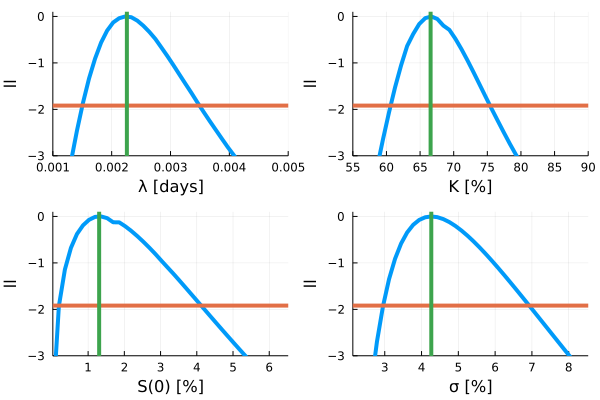

In [13]:
s1=plot(λrange,nllλ,xlim=(λmin,λmax),lw=4,ylim=(-3,0.1),xlabel="λ [days]",ylabel="ll",legend=false,xticks=[0.001, 0.002,0.003,0.004,0.005])
s1=hline!([-1.92],lw=4)
s1=vline!([λmle],lw=4)
s2=plot(Krange,nllK,xlim=(Kmin,Kmax),lw=4,ylim=(-3,0.1),xlabel="K [%]",ylabel="ll",legend=false)
s2=hline!([-1.92],lw=4)
s2=vline!([Kmle],lw=4)
s3=plot(C0range,nllC0,xlim=(C0min,C0max),lw=4,ylim=(-3,0.1),xlabel="S(0) [%]",ylabel="ll",legend=false)
s3=hline!([-1.92],lw=4)
s3=vline!([C0mle],lw=4)
s4=plot(σrange,nllσ,xlim=(σmin,σmax),lw=4,ylim=(-3,0.1),xlabel="σ [%]",ylabel="ll",legend=false)
s4=hline!([-1.92],lw=4)
s4=vline!([σmle],lw=4)


s5=plot(s1,s2,s3,s4,layout=(2,2),legend=false)
display(s5)
savefig(s5, "profiles_S3.pdf")

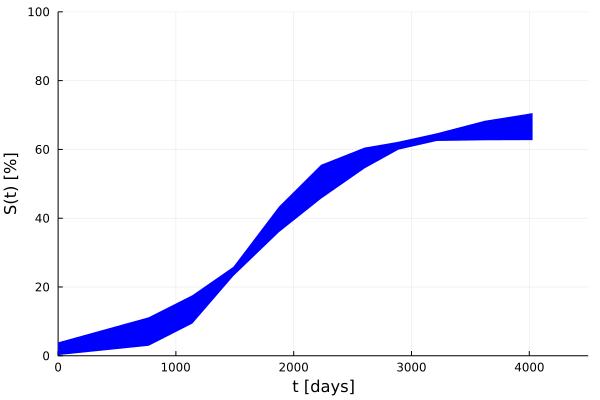

In [25]:
q2=plot(t,Cmle,w=0,c=:blue,ribbon=(Cmle.-λm,λp.-Cmle),fillalpha=1.0,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t [days]",ylabel="S(t) [%]")
#Plots the prediction interval based on λ

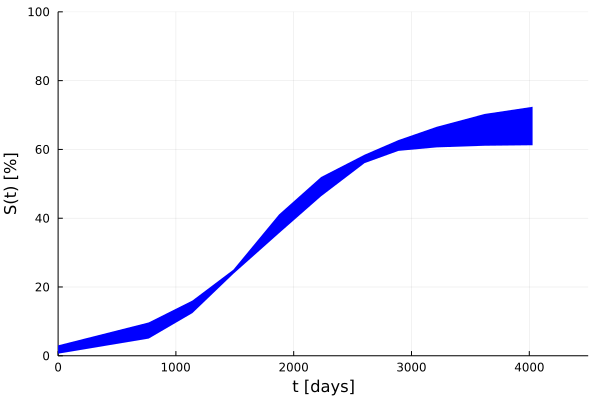

In [24]:
q3=plot(t,Cmle,w=0,c=:blue,ribbon=(Cmle.-Km,Kp.-Cmle),fillalpha=1.0,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t [days]",ylabel="S(t) [%]")
#Plots the prediction interval based on K

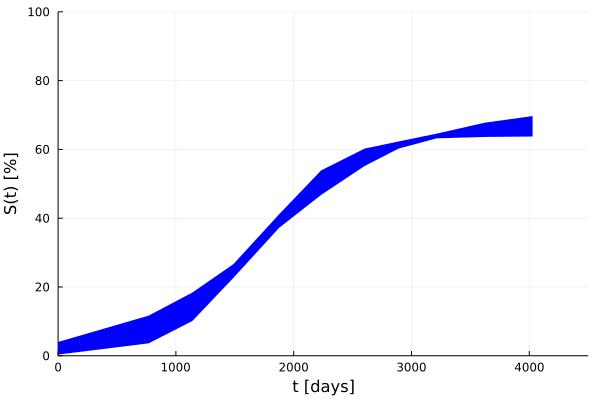

In [26]:
q4=plot(t,Cmle,w=0,c=:blue,ribbon=(Cmle.-C0m,C0p.-Cmle),fillalpha=1.0,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t [days]",ylabel="S(t) [%]")
#Plots the prediction interval based on S(0)

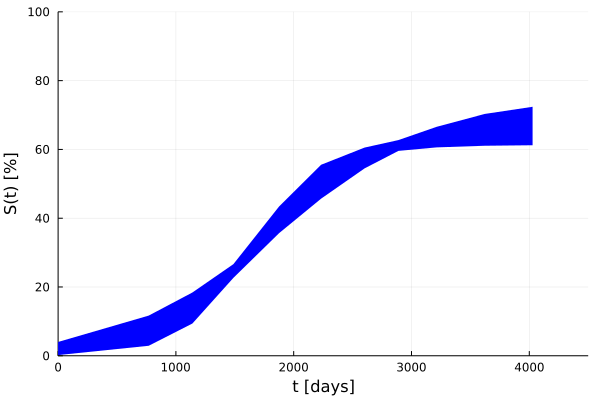

In [17]:
Up=zeros(length(t))
Um=zeros(length(t))
for i in 1:length(t)
Up[i] = max(λp[i],Kp[i],C0p[i])
Um[i] = min(λm[i],Km[i],C0m[i])
end
q5=plot(t,Cmle,w=0,c=:blue,ribbon=(Cmle.-Um,Up.-Cmle),fillalpha=1.0,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t [days]",ylabel="S(t) [%]")
#Plots the prediction interval based on the union of the three parameter-wise profiles above

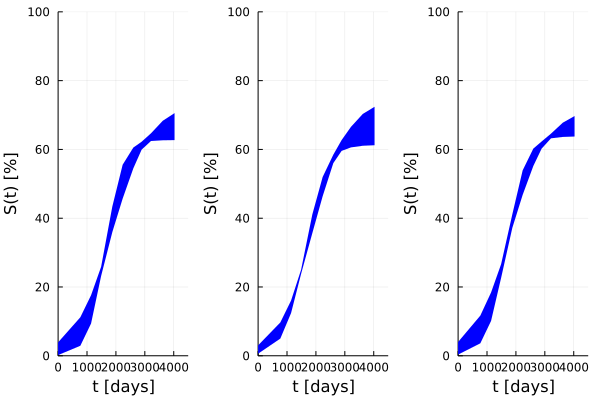

In [18]:
q6=plot(q2,q3,q4,layout=(1,3),legend=false)
display(q6)
savefig(q6, "Intervals_S3.pdf")

In [22]:
ss=plot(t,Cmle,label=false)
λλ=0.001:0.0001:0.004
KK=55:0.25:80
CC0=0.0:0.2:6.0
ll=zeros(length(λλ),length(KK),length(CC0))
predictll=zeros(length(t),length(λλ)*length(KK)*length(CC0))

for i in 1:length(λλ)
    for j in 1:length(KK)
        for k in 1:length(CC0)
ll[i,j,k]=error(data,[λλ[i],KK[j],CC0[k],σmle]) #This is the loglikelihood
        end
end
end

num=0
for i in 1:length(λλ)
    for j in 1:length(KK)
        for k in 1:length(CC0)     
       if ll[i,j,k]-maximum(ll) > -3.91
       num=num+1
                predictll[:,i*j*k]=model(t,[λλ[i],KK[j],CC0[k],σmle]) 
       ss=plot!(t,predictll[:,i*j*k],label=false,color=:red,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t [days]",ylabel="S(t) [%]")         
       end
            
        
        end
end
end

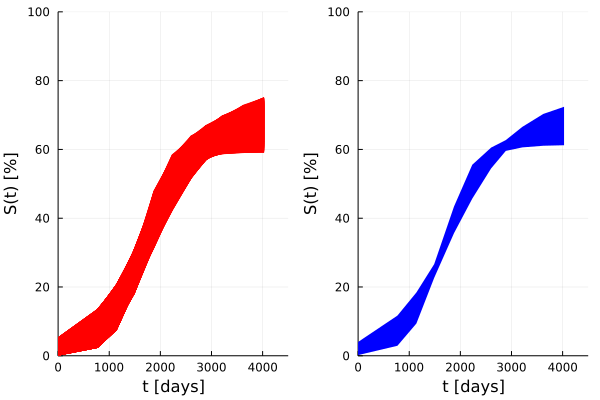

In [23]:
#display(ss)
sss=plot(ss,q5,layout=(1,2),legend=false) #Compares plot ss of the prediction intervals from the full lielihood (red) with the plot of the prediction intervals from the union of the parameter-wise prediction intervals (blue)
display(sss)
savefig(sss, "PredictionComparison_S3.pdf")

In [21]:
savefig(q5, "Union_S3.pdf")